In [1]:
from space.planets import venus
from orbit.pointing import simulation
from orbit.geometry import getTiming
from orbit.envision import loadSV
from measurement.measurement import state_vector

""" System Packages """
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
import os

In [2]:
sim_folder = os.path.join(r"C:\Users",
                          r"ishuwa.sikaneta",
                          r"OneDrive - ESA",
                          r"Documents",
                          r"ESTEC",
                          r"Envision",
                          r"PointingSimulations")

### Load ESOC-supplied orbit file

In [3]:
sv = loadSV()

# Simulate Pointing Errors

The following class simulates pointing errors for an Envision-type SAR

In [4]:
eSim = simulation(planet = venus(),
                  e_ang = 14.28, # The effective angle of the beam relative to spacecraft coordinate frame
                  azAxis = 5.5,  # The length of the reflector in the azimuth direction. Leads to 0.99 degrees
                  elAxis = 0.6125,  # The length of the reflector in the elevation direction. Leads to 8.9 degrees
                  carrier = 3.15e9)

### Select a subset of state vectors

Select a range of state vectors to use for error simulation

In [5]:
selection_range = [270, 44480, 2]
mysvs = eSim.state(sv.measurementData, selection_range)
 
times = [(sv.measurementTime[k] - sv.measurementTime[0])/np.timedelta64(1, 's') 
         for k in range(*selection_range)]

### Test the simulation of errors

Test right looking configuration with an off-nadir angle of -18.7 and left looking with an off-nadir of 18.7. The off-nadir angle of 18.7 corresponds to a 20 degree incidence angle. An off-nadir angle of 37.6 degrees corresponds to an incidence angle of 40 degrees.

In [6]:
off_nadir = -18.7

### Define Covariances

Define the set of input covariance matrices for the simulation. These have been determined from the pointing justification document (ESA) and the JPL-provided pointing spreadsheet.

Norm of u: 1.000000
u*e1: 0.000000
u*e2: 0.947126, v: 0.947210
uP*VP: 0.000000
Roll: -32.9781, Pitch: 0.0063, Yaw: -0.0098
Percent of Doppler centroids in violation: 4.8167


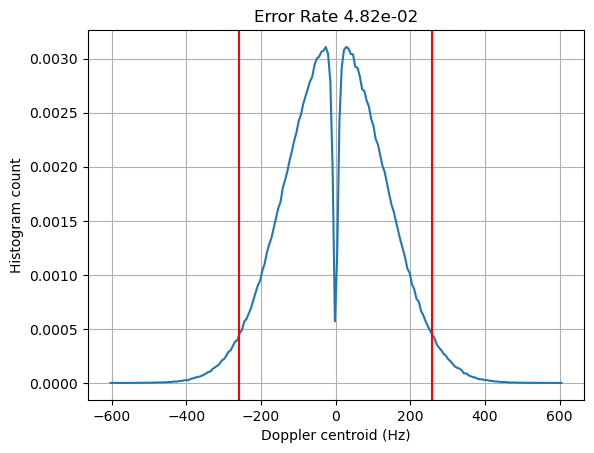

Percent of Swaths in violation: 4.6157


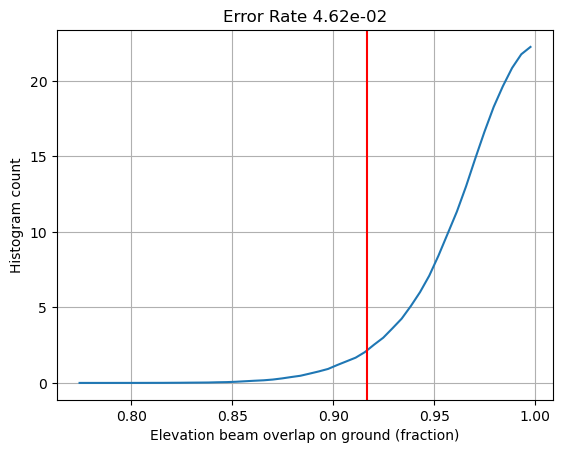

In [19]:
X = mysvs[np.random.randint(0,len(mysvs))]
""" Define a margin for covariances in terms of RollPitchYaw """
margin = np.diag([(11.5e-3/2)**2, (0.2e-3/2)**2, (0.2e-3/2)**2])

""" Define the covariances for Thales Alenia Space data """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for TAS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([1.95e-3, 0.91e-3, 1.22e-3])/2)**2 + margin).tolist(), #TAS values
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dCdN",
        "errorDefinition": "TCN",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/10,
                         eleErrThreshold = 1/12,
                         loglevel=3)

In [8]:
""" RPY 2-sigma values from T error ESOC """
R_AEUt = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[3:6,3:6]
print(R_AEUt)
R_RPYt = eSim.aeu2rpyCovariance(R_AEUt)
print(R_RPYt)
print(np.diag(R_RPYt))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt))*1e3*2)

[[ 3.63710478e-07 -3.56630726e-11  1.23006604e-07]
 [-3.56630726e-11  1.49447029e-14 -1.20612315e-11]
 [ 1.23006604e-07 -1.20612315e-11  4.16007391e-08]]


[[ 1.77944126e-14 -3.13858724e-11 -2.03553740e-11]
 [-3.13858724e-11  2.85586153e-07  1.85217426e-07]
 [-2.03553740e-11  1.85217426e-07  1.20123103e-07]]
[1.77944126e-14 2.85586153e-07 1.20123103e-07]
2-sigma values (Roll, Pitch, Yaw)
[2.66791398e-04 1.06880523e+00 6.93175600e-01]


In [9]:
""" RPY 2-sigma values from velocity errors ESOC """
R_AEUv = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[6:9,6:9]
print(R_AEUv)
R_RPYv = eSim.aeu2rpyCovariance(R_AEUv)
print(R_RPYv)
print(np.diag(R_RPYv))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYv))*1e3*2)

[[ 1.84930706e-10  6.06370252e-12 -5.46387150e-10]
 [ 6.06370252e-12  1.98823299e-13 -1.79155186e-11]
 [-5.46387150e-10 -1.79155186e-11  1.61432876e-09]]
[[ 1.97949551e-13  1.02501869e-11 -1.57966209e-11]
 [ 1.02501869e-11  5.30774045e-10 -8.17978849e-10]
 [-1.57966209e-11 -8.17978849e-10  1.26059185e-09]]
[1.97949551e-13 5.30774045e-10 1.26059185e-09]
2-sigma values (Roll, Pitch, Yaw)
[0.00088983 0.04607707 0.07100963]


In [10]:
""" RPY 2-sigma values from across-track and radial errors ESOC """
R_AEUp = np.array([[0,0,0],
                  [0,res["computed"]["ErrorCovariance"]["BlockCovariance"][9][9],0],
                  [0,0,0]])
print(R_AEUp)
R_RPYp = eSim.aeu2rpyCovariance(R_AEUp)
print(R_RPYp)
print(np.diag(R_RPYp))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYp))*1e3*2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.92086107e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.92259998e-09 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[1.92259998e-09 0.00000000e+00 0.00000000e+00]
2-sigma values (Roll, Pitch, Yaw)
[0.08769493 0.         0.        ]


In [11]:
""" RPY 2-sigma values from instrument JPL """
R_AEUi = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[10:13,10:13]
print(R_AEUi)
R_RPYi = eSim.aeu2rpyCovariance(R_AEUi)
print(R_RPYi)
print(np.diag(R_RPYi))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYi))*1e3*2)

[[ 1.32712107e-07 -7.24959296e-10  1.23380527e-08]
 [-7.24959296e-10  1.42640163e-06 -1.69021841e-09]
 [ 1.23380527e-08 -1.69021841e-09  1.77645997e-07]]
[[ 1.43831193e-06 -3.90386855e-09 -3.23436900e-09]
 [-3.90386855e-09  1.29218282e-07  1.56056127e-10]
 [-3.23436900e-09  1.56056127e-10  1.81550030e-07]]
[1.43831193e-06 1.29218282e-07 1.81550030e-07]
2-sigma values (Roll, Pitch, Yaw)
[2.39859286 0.71893889 0.85217376]


In [12]:
""" Old way of computing ephemeris cross and radial error """
v = np.array([np.sin(np.radians(res["given"]["off_nadir"])), 
              np.cos(np.radians(res["given"]["off_nadir"]))])
RAEUat = np.zeros((3,3))
#from measurement.measurement import state_vector
mysv = state_vector(planet = venus())
#mysv.add(np.datetime64("2000-01-01T00:00:00.000000"), sv.toPCR(X, 0))
mysv.add(np.datetime64("2000-01-01T00:00:00.000000"), X)
r, rhat, inc, _, _ = getTiming(mysv, [np.radians(off_nadir)], 0)
sigma_e_sqr = v.T.dot(np.array(covariancesESOCTwoDay["orbitAcrossTrack"]["R"])).dot(v)/r[0]**2
print(2*np.sqrt(sigma_e_sqr)*1e3)

0.49648661258605575


In [13]:
print("2-sigma values (Roll - Y, Pitch - Z, Yaw - X)")
print(np.sqrt(np.diag(R_RPYt+R_RPYv+R_RPYp))*1e3*2)

2-sigma values (Roll - Y, Pitch - Z, Yaw - X)
[0.08769985 1.06979798 0.69680326]


In [14]:
print("2-sigma values (Azimuth, Elevation, Tilt)")
print(np.sqrt(np.diag(R_AEUt+R_AEUv+R_AEUp))*1e3*2)

2-sigma values (Azimuth, Elevation, Tilt)
[1.20647488 0.08766014 0.41576468]
